# <b>시계열 프로젝트3</b>

## <b>비지도학습(1)</b>

In [1]:
# 시계열 데이터를 클러스터링을 할때
# 시간에 따라서 무브먼트가 있을때 어떠한 부분이 비슷하게 움직일까
# 비슷한 구간의 움직임
# 데이터만을 가지고 인사이트를 뽑아냄

In [2]:
# 구간포착이 유용한 경우 : 금리, 자산가격의 움직임, comodity
# 소비자 물가지수(cpi)
# 심장 egg, 뇌파 데이터

### 경제 데이터 이용 및 소개

In [3]:
! pip install tsmoothie # 시계열 관측치 스무딩

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install tslearn # DTW 이용한 시계열 클러스터링

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tsmoothie.smoother import *
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import warnings
warnings.simplefilter('ignore')

In [6]:
## Read data

filename = 'https://github.com/mchoimis/tsdl/raw/main/macro/stock.csv'
df = pd.read_csv(filename, index_col=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168615 entries, 0 to 168614
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   stock      168615 non-null  object 
 1   timestamp  168615 non-null  int64  
 2   open       168615 non-null  float64
 3   high       168615 non-null  float64
 4   low        168615 non-null  float64
 5   adj_close  168615 non-null  float64
 6   volume     168615 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 10.3+ MB


In [8]:
df.head()

,stock,timestamp,open,high,low,adj_close,volume
0,GERN,1532988000,3.34,3.59,3.59,3.59,4650479
1,GERN,1532901600,3.36,3.45,3.45,3.30,3571600
2,GERN,1532642400,3.44,3.50,3.50,3.34,2928697
3,GERN,1532556000,3.26,3.56,3.56,3.44,4209642
4,GERN,1532469600,3.37,3.42,3.42,3.22,3568900


In [9]:
# Make timestamp datetime
df['timestamp'] = df.timestamp.apply(datetime.fromtimestamp)
df = df.loc[df.timestamp.dt.year > 2014].copy()
df.sort_values(['stock','timestamp'], inplace=True)

In [11]:
df.head() # timestamp corrected

,stock,timestamp,open,high,low,adj_close,volume
9960,AAPL,2015-01-01 23:00:00,104.25,104.29,104.29,102.32,53204626
9959,AAPL,2015-01-04 23:00:00,101.35,101.68,101.68,99.44,64285491
9958,AAPL,2015-01-05 23:00:00,99.71,100.54,100.54,99.45,65797116
9957,AAPL,2015-01-06 23:00:00,100.33,101.26,101.26,100.84,40105934
9956,AAPL,2015-01-07 23:00:00,102.23,104.96,104.96,104.72,59364547


In [10]:
df.tail()

,stock,timestamp,open,high,low,adj_close,volume
141050,URBN,2018-07-24 22:00:00,45.08,46.22,46.22,45.84,1000726
141049,URBN,2018-07-25 22:00:00,45.79,46.94,46.94,45.92,912984
141048,URBN,2018-07-26 22:00:00,45.92,46.03,46.03,43.73,1300353
141047,URBN,2018-07-29 22:00:00,43.72,44.78,44.78,43.95,1537316
141046,URBN,2018-07-30 22:00:00,44.16,44.96,44.96,44.40,1328212


In [13]:
### View Close Price Series unstacked

df_close = df.set_index(['stock','timestamp'])['adj_close'].unstack()  ##
df_close = df_close.loc[~df_close.isna().any(axis=1)].copy()
df_close.columns = range(len(df_close.columns))
df_close.head(10)

,0,1,2,3,4,5,6,7,8,9,...,891,892,893,894,895,896,897,898,899,900
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,102.32,99.44,99.45,100.84,104.72,104.83,102.24,103.15,102.76,99.97,...,189.73,191.21,190.77,190.94,192.33,194.14,193.53,190.31,189.25,189.63
ADBE,72.34,71.98,70.53,71.11,72.92,71.84,71.12,70.59,69.99,70.29,...,259.78,257.68,257.54,259.47,257.49,263.17,261.93,254.81,242.32,244.68
ADSK,59.53,58.66,57.50,57.38,58.80,58.27,57.29,57.34,56.41,55.71,...,137.43,134.50,134.32,134.50,132.31,135.85,136.14,131.16,127.00,128.44
AKRX,36.07,37.12,36.42,38.16,40.28,40.72,40.51,41.28,41.74,40.46,...,16.85,17.31,17.47,17.27,16.98,17.49,17.60,18.23,18.31,18.52
AMAT,23.59,22.83,21.97,22.18,22.88,22.91,22.36,22.05,21.75,22.04,...,48.06,46.46,46.55,46.22,45.70,45.75,46.95,48.08,47.69,48.41
AMZN,308.52,302.19,295.29,298.42,300.46,296.93,291.41,294.74,293.27,286.95,...,1842.92,1812.97,1813.70,1802.00,1829.24,1863.61,1808.00,1817.27,1779.22,1777.44
ATVI,19.54,19.27,18.91,18.50,18.69,18.35,18.31,18.02,18.38,18.01,...,81.27,80.61,79.65,79.75,78.41,79.45,77.65,75.36,72.75,73.42
BBBY,73.57,72.73,72.32,74.99,76.18,71.04,70.40,71.10,71.10,69.19,...,18.72,19.23,18.78,19.17,19.04,18.86,18.99,18.82,19.40,18.73
BIDU,223.08,219.79,220.18,224.35,229.21,226.90,220.89,219.60,216.82,215.97,...,269.42,262.42,259.98,260.38,256.48,262.91,260.35,255.09,251.40,247.18


### 심화 Point: 시계열 비지도학습의 유의점과 해석방법

In [14]:
# 클러스터링을 이용하면 다른 시간대라도 움직임이 비슷하면 디텍트를 할 수 있다. 

In [15]:
## Smooth price series
# 스무딩

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), window_shape=window_shape)
smoother.smooth(df_close.loc['AMZN'])
print(df_close.loc['AMZN'].shape)

low, up = smoother.get_intervals('prediction_interval') # only for visualization

(901,)


In [16]:
## Scale price series - raw data 

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)
raw_scaled.shape # 몇차원

(882, 20, 1)

In [17]:
## Make clusters using raw price series
## DTW(Dynamic Time Warping)

kmeans_raw = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=123) ###
kmeans_raw.fit(raw_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=123)

In [18]:
kmeans_raw.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 0, 0, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1,

In [19]:
kmeans_raw.cluster_centers_

array([[[0.11912454],
        [0.27923992],
        [0.32484923],
        [0.26657079],
        [0.26656062],
        [0.26812416],
        [0.19371501],
        [0.44309232],
        [0.61706048],
        [0.85398259],
        [0.96151998],
        [0.96544551],
        [0.86892286],
        [0.65299432],
        [0.76658166],
        [0.79899568],
        [0.42168741],
        [0.16930773],
        [0.34023571],
        [0.59618414]],

       [[0.75433375],
        [0.38912121],
        [0.51696268],
        [0.13798195],
        [0.00641706],
        [0.00388417],
        [0.00388417],
        [0.03125415],
        [0.25587865],
        [0.4737    ],
        [0.44516659],
        [0.61914255],
        [0.56097796],
        [0.57842059],
        [0.74853984],
        [0.89297295],
        [0.81525201],
        [0.82530986],
        [0.71742336],
        [0.86250416]],

       [[0.72848512],
        [0.91015267],
        [0.84393558],
        [0.81197283],
        [0.93941893],
      

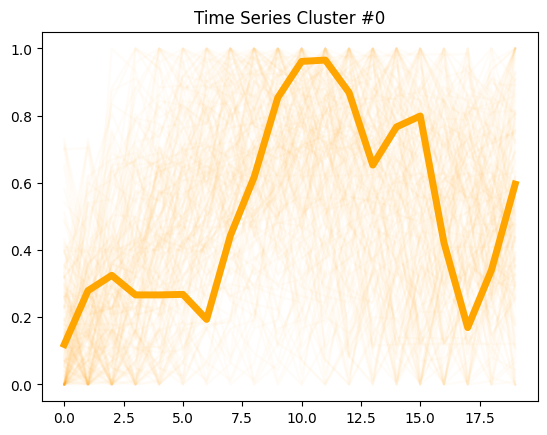

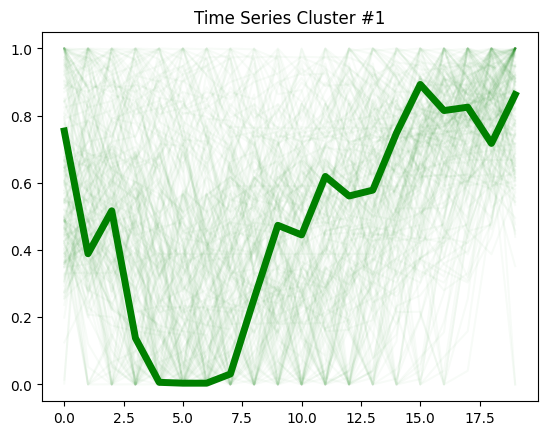

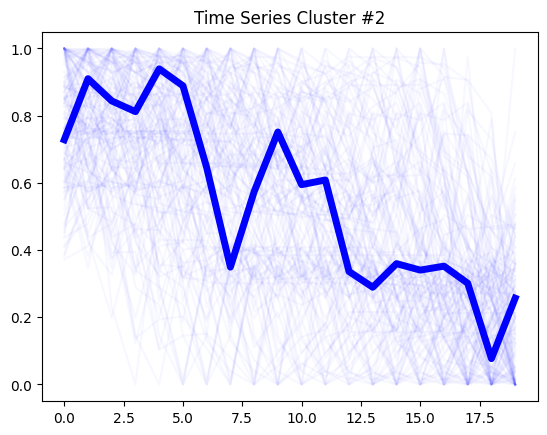

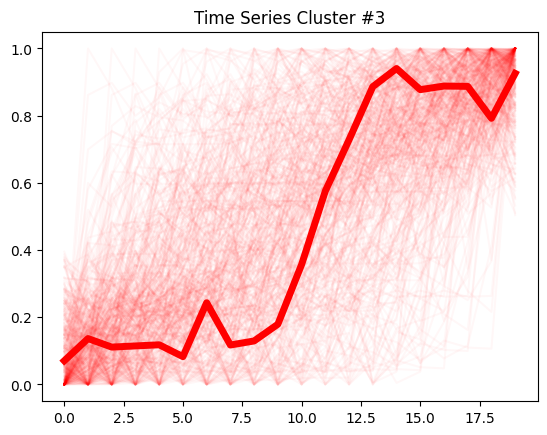

In [20]:
### Visualize price series clusters

colors = {0:'orange',1:'green',2:'blue',3:'red'}

for c in range(kmeans_raw.n_clusters):    
    plt.plot(np.squeeze(raw_scaled[kmeans_raw.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_raw.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"Time Series Cluster #{c}")
    plt.show()
    # price 무브먼트 이기 때문에 0에서 1로 극단적으로 보일 수 있다.

In [21]:
## Make clusters using raw price series with different random seed

kmeans_raw_1234 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=1234) ###
kmeans_raw_1234.fit(raw_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=1234)

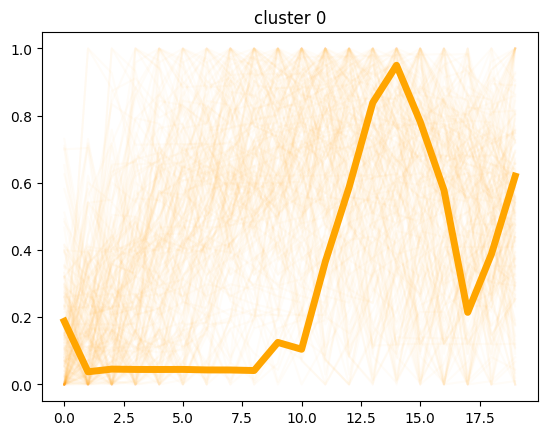

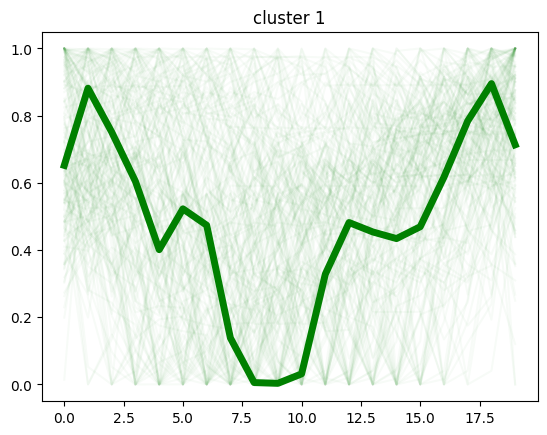

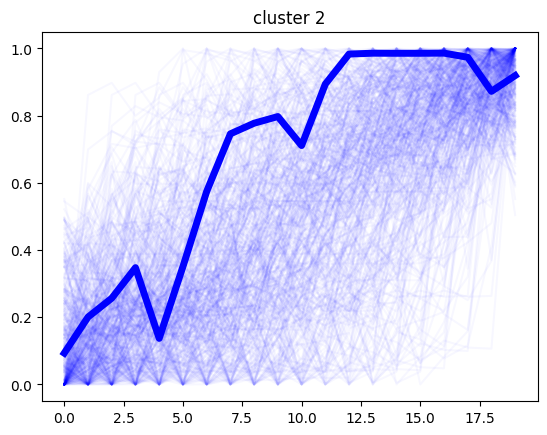

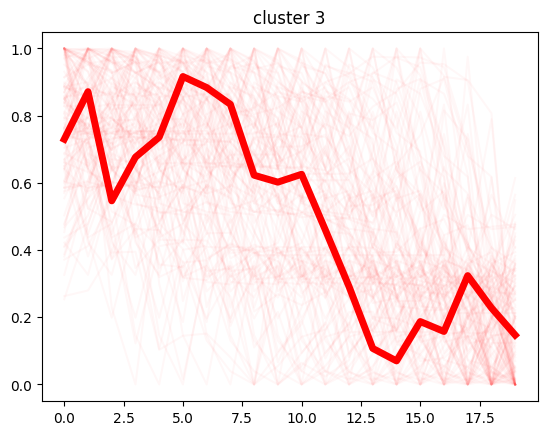

In [22]:
## Plot cluster samples
# 랜덤시드를 바꾸었을 때

colors = {0:'orange',1:'green',2:'blue',3:'red'}

for c in range(kmeans_raw_1234.n_clusters):
    plt.plot(np.squeeze(raw_scaled[kmeans_raw_1234.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_raw_1234.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    plt.show()

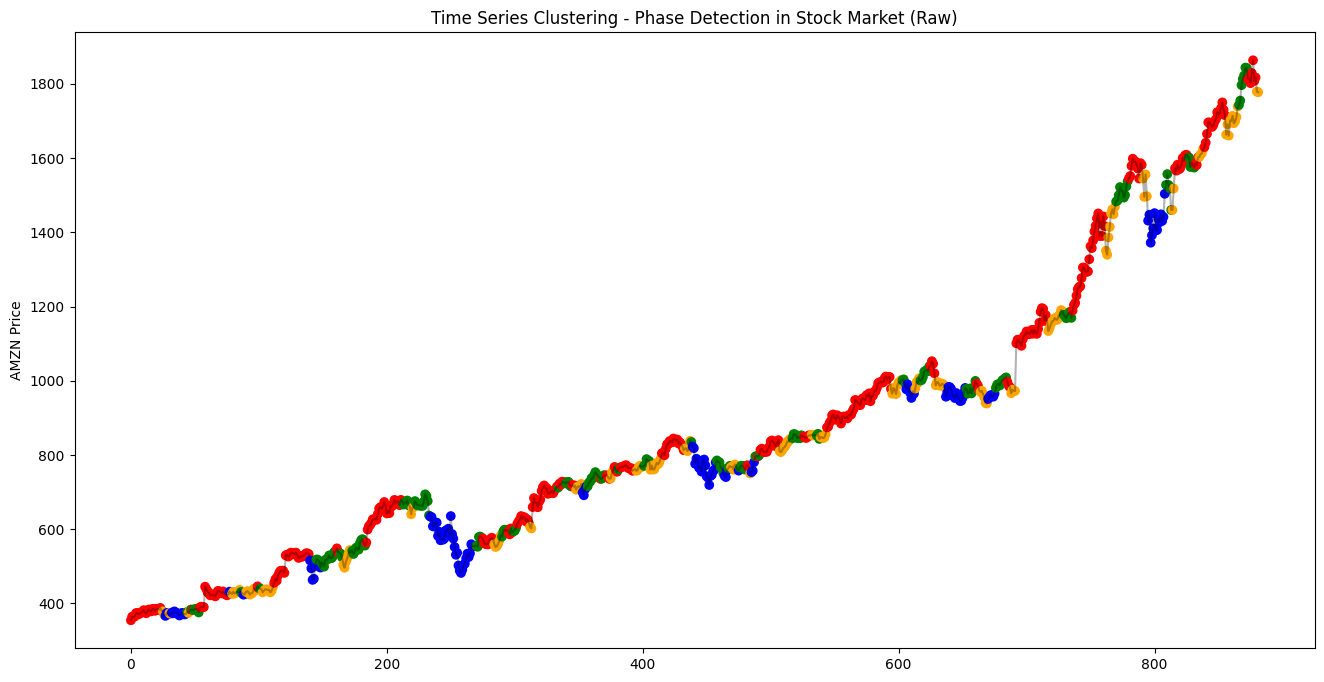

In [23]:
### Visualize price series clusters

plt.figure(figsize=(16,8))
plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in kmeans_raw.labels_])
#plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), df.timestamp[window_shape::100].dt.date.unique())
plt.ylabel('AMZN Price')
plt.title("Time Series Clustering - Phase Detection in Stock Market (Raw)")
plt.show()

### 분석결과 및 해석

<b>참고: Lowess 평활화 (Lowess Smoothing) </b> 

Locally Weighted Scatterplot Smoothing

In [24]:
## Smooth price series

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), window_shape=window_shape)
smoother.smooth(df_close.loc['AMZN'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

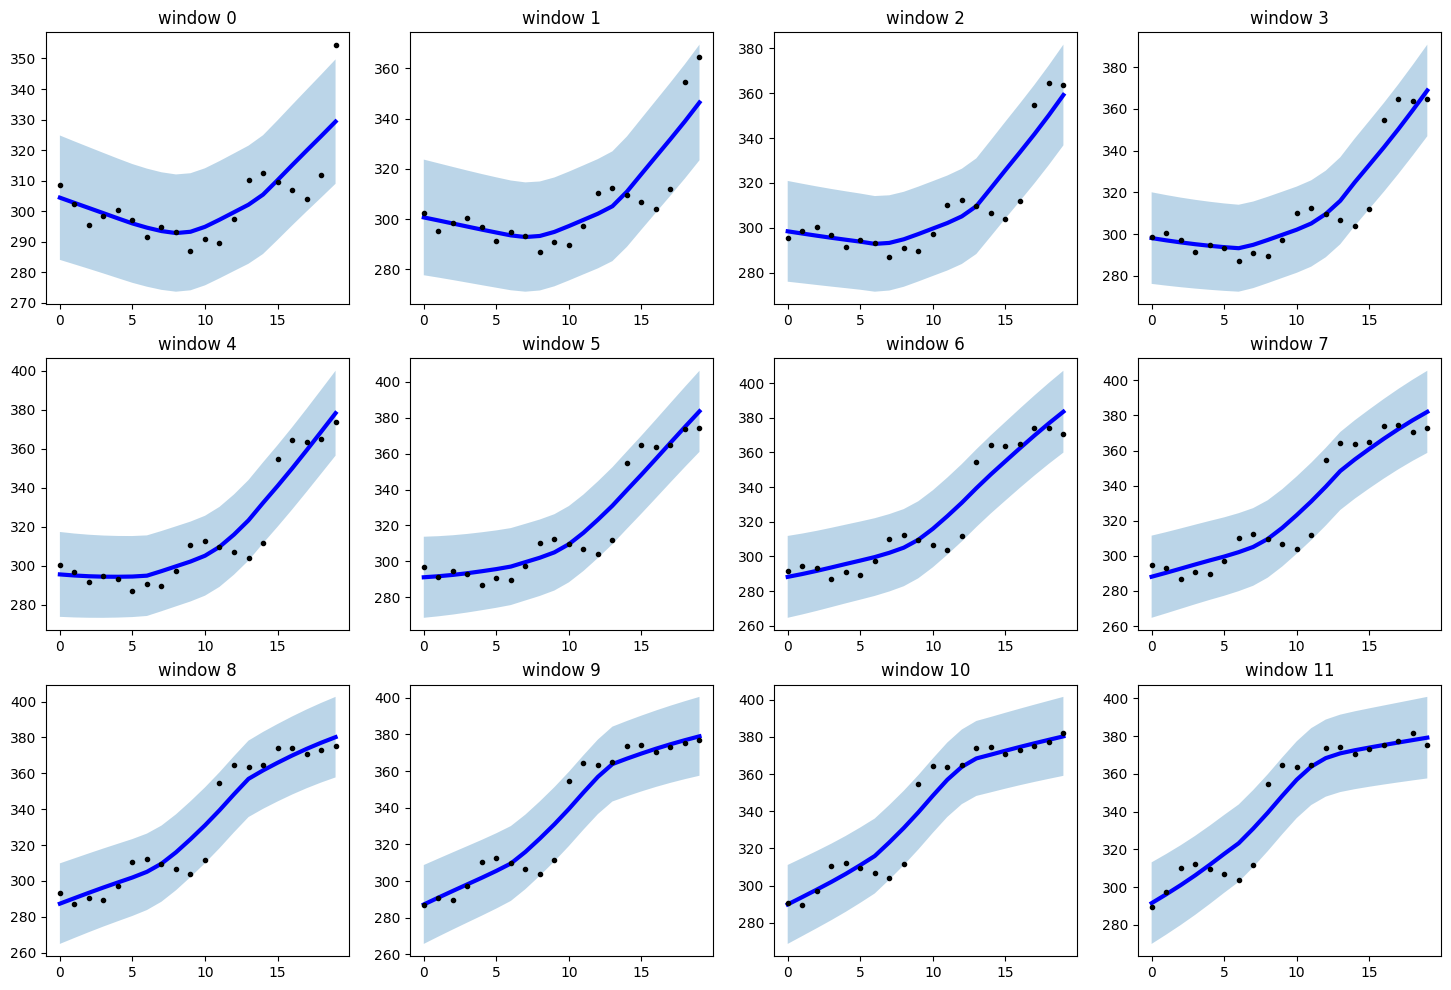

In [25]:
### Plot the first 12 smoothed windows

plt.figure(figsize=(18,12))

for i,(true,smooth) in enumerate(zip(smoother.Smoother.data, smoother.Smoother.smooth_data)):
    
    if i == 12:
        break
    
    plt.subplot(3,4, i+1)
    plt.plot(smooth, linewidth=3, color='blue')
    plt.plot(true, '.k')
    plt.fill_between(range(len(true)), low[i], up[i], alpha=0.3)
    plt.title(f"window {i}")

In [26]:
## Scale smoothed series

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

(882, 20, 1)

In [28]:
## Make clusteres using smoothed series

kmeans_sm = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
kmeans_sm.fit(smooth_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, random_state=33)

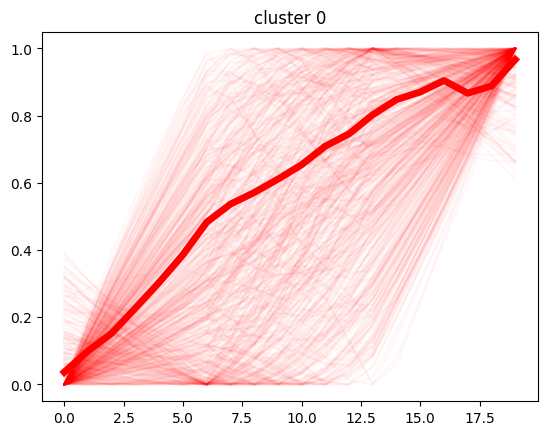

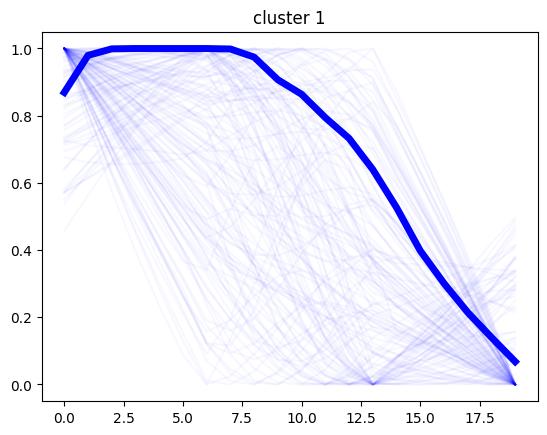

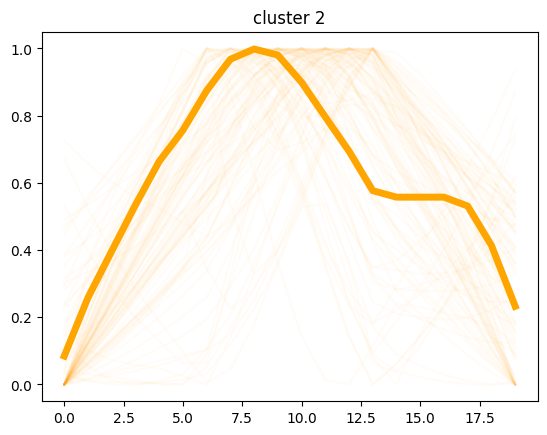

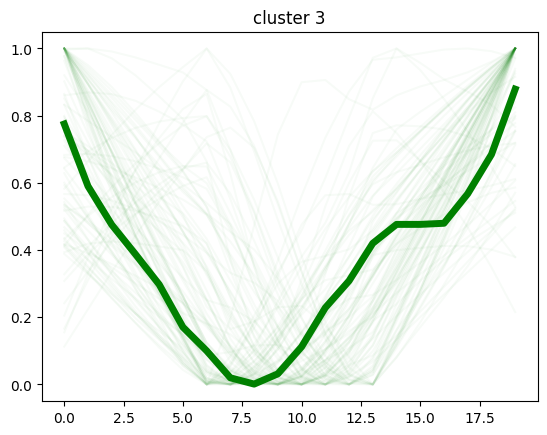

In [29]:
## Plot clusters

colors = {0:'red',1:'blue',2:'orange',3:'green'}

for c in range(kmeans_sm.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[kmeans_sm.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(kmeans_sm.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()
    # 무브먼트가 부드러워졌다.

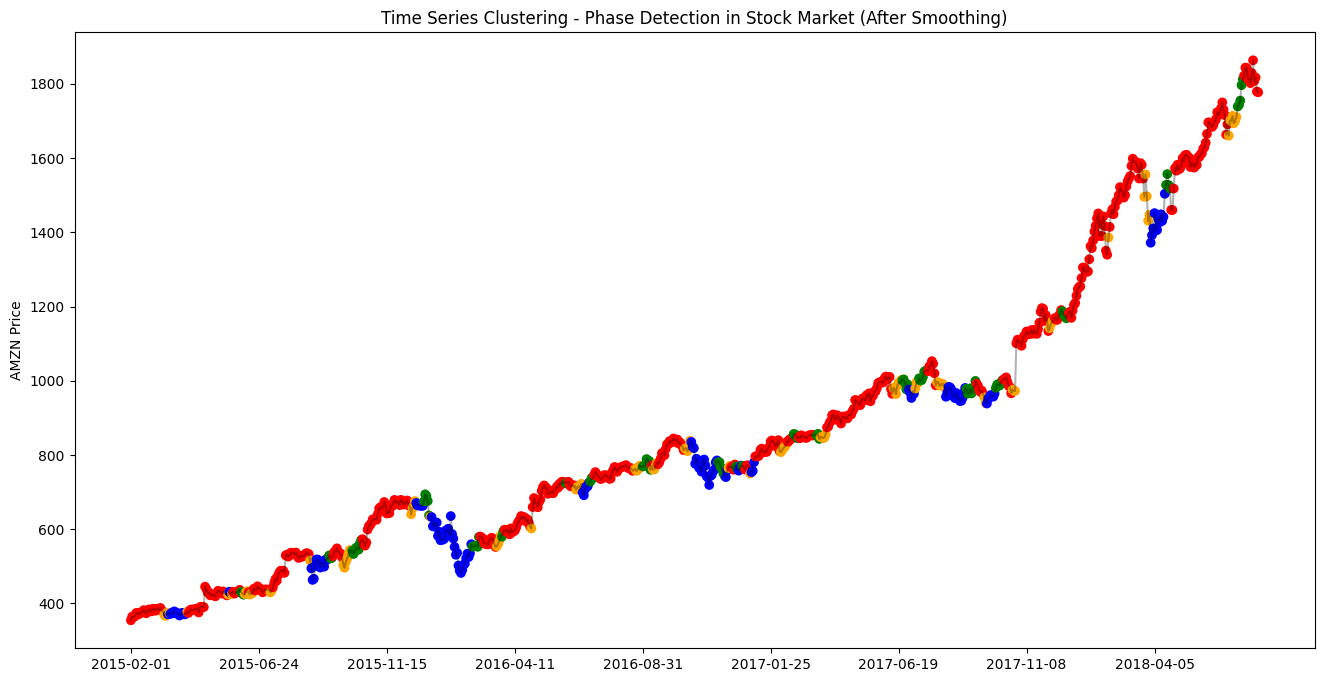

In [30]:
## Plot Clusters 

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in kmeans_sm.labels_])

plt.xticks(range(0,len(df.timestamp.unique())-window_shape, 100), 
           df.timestamp.dt.date.unique()[window_shape::100])
plt.ylabel('AMZN Price')
plt.title('Time Series Clustering - Phase Detection in Stock Market (After Smoothing)')
plt.show()